Loading required package: limma
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, tab

keep
FALSE  TRUE 
25960 22677 

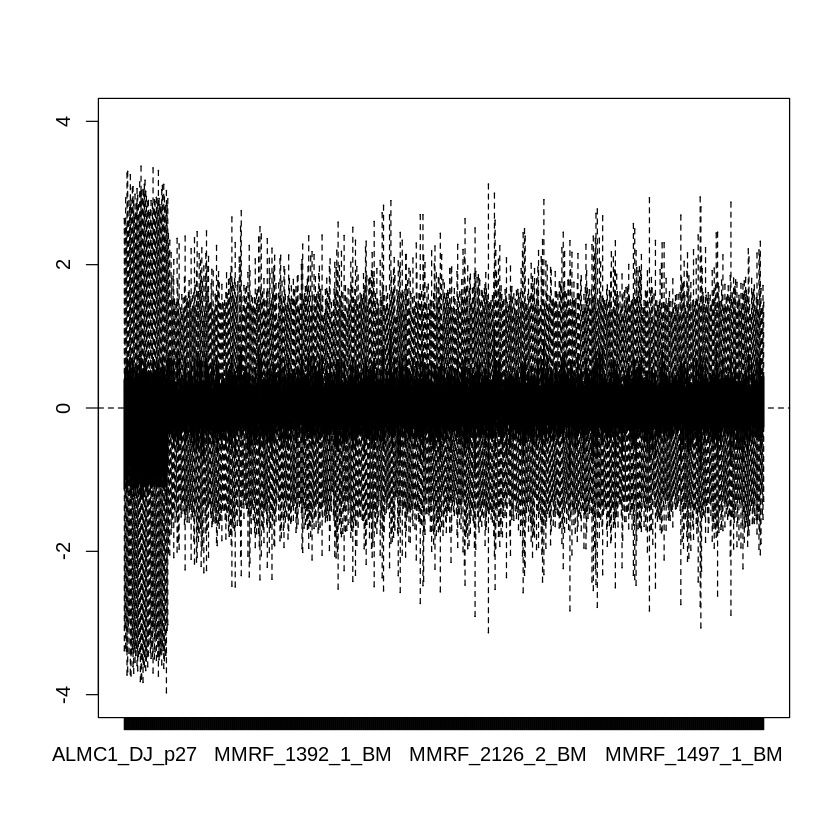

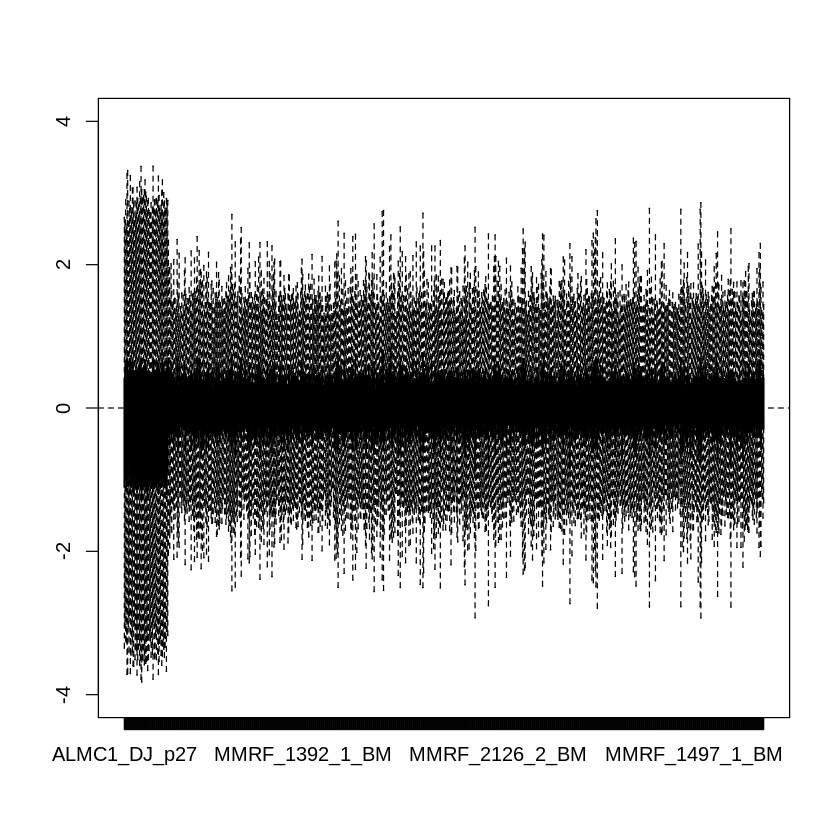

In [1]:
setwd('~/Downloads/proj/')

library(data.table)
library(edgeR)
library(EDASeq)
library(RUVSeq)
library(RColorBrewer)

#reading data files
MM_cell_line = data.frame(fread("HMCL66_HTSeq_GENE_Counts_v2.txt"))
MM_patients = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))

#finding ensembl IDs in common
ensembl_intersect = intersect(MM_cell_line$Sample, MM_patients$GENE_ID)

#assigning rownames to each
rownames(MM_cell_line) = MM_cell_line$Sample
rownames(MM_patients) = MM_patients$GENE_ID

#removing columns associated with gene IDs and names as rownames have been assigned
MM_cell_line = MM_cell_line[ensembl_intersect, -(1:2)]
MM_patients = MM_patients[ensembl_intersect, -1]

#combining partly processed data frames
MM_combined = cbind(MM_cell_line, MM_patients)

#Getting counts per million for each gene
MM_cell_line_cpm = cpm(MM_cell_line)
MM_patients_cpm = cpm(MM_patients)

##pre-processing

# remove low count genes (genes that have 0 counts > 2)
keep <- rowSums(cpm(MM_combined)>1) > 2
table(keep)
MM_combined.filtered <- MM_combined[keep,]

# normalize the samples using upper-quartile/TMM (account for library size)

#phenodata annotations
combined_annot = data.frame(colnames(MM_combined.filtered))
combined_annot$type = "Patient"
combined_annot$type[1:ncol(MM_cell_line)] = "Cell_Line"

#making new seq expression set objectg
set <- newSeqExpressionSet(as.matrix(round(MM_combined.filtered)), phenoData = data.frame(combined_annot, row.names=colnames(MM_combined.filtered)))
set <- betweenLaneNormalization(set, which="upper")

# check for batch effects with RLE plots

x <- as.factor(combined_annot$type)

colors <- brewer.pal(3, "Set2")
#pdf("UQ_plot.pdf")
plotRLE(set, outline=FALSE, ylim=c(-4, 4), col=colors[x])
#dev.off()

design <- model.matrix(~x, data=pData(set))
y <- DGEList(counts=counts(set), group=x)
y <- calcNormFactors(y, method="upperquartile")
y <- estimateGLMCommonDisp(y, design)
y <- estimateGLMTagwiseDisp(y, design)
fit <- glmFit(y, design)
lrt <- glmLRT(fit, coef=2)
top <- topTags(lrt, n=nrow(set))$table
empirical <- rownames(set)[which(!(rownames(set) %in% rownames(top)[1:21677]))]


set2 <- RUVg(set, empirical, k=1)
#pData(set2)
plotRLE(set2, outline=FALSE, ylim=c(-4, 4), col=colors[x])

In [ ]:
empirical <- rownames(set)[which(!(rownames(set) %in% rownames(top)[1:10000]))]
set2 <- RUVg(set, empirical, k=1)
#pData(set2)
plotRLE(set2, outline=FALSE, ylim=c(-4, 4), col=colors[x])

In [3]:
length(empirical)

[1] 22577